In [1]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from scipy.stats.qmc import Halton

from magpi.prelude import *
from magpi import r_fun
from magpi.domain import Sphere
from magpi.integrate import gauss
from magpi.calc import *
from magpi.surface_integral import charge_tensor, source_tensor, single_layer_potential, scalar_potential_charge
%matplotlib widget

In [2]:
R = 1.0

# The parametrization is required to solve the single layer potential 
# via Taylor expansion

def sphere_parametrization(u):
    phi = u[..., 0] * pi
    theta = u[..., 1] * 2 * pi
    x = R * sin(phi) * cos(theta)
    y = R * sin(phi) * sin(theta)
    z = R * cos(phi)
    return jnp.stack([x, y, z], axis=-1)

# The approximate distance function 
adf = r_fun.sphere(R)

_u, _v = jnp.linspace(0, 1, 9), jnp.linspace(0, 1, 9)

# Create collocation points and validation set
domain = Sphere(R, (0,0,0))
X = array(Halton(3, seed=561).random(2**12))

# Collocation points are uniformly mapped into the sphere.
# Note that this does not yield the same accuracy
# as Monte Carlo on a cuboid geometry.
X = domain.transform(X)

X_val = array(Halton(3, seed=125).random(2**12))
X_val = domain.transform(X_val)

In [3]:
mag = lambda x: x / norm(x, axis=-1, keepdims=True)


# make a solver for the stray field using the scalar potential
def solve_stray_field(W_elm, b_elm):
    # compute elm:
    h_elm = lambda x: nn.gelu(W_elm @ x) + b_elm
    u_elm = lambda x: h_elm(x) * adf(x)
    Q_phi1 = vmap(lambda x: -laplace(u_elm)(x))(X)

    Pinv_phi1 = jnp.linalg.pinv(Q_phi1)
    b1 = vmap(divergence(mag))(X)
    params_phi1 = -Pinv_phi1 @ b1
    phi1 = lambda x: u_elm(x) @ params_phi1  # elm solution
    
    # this is used to simplify the computation of the single layer potential
    phi1_without_adf = lambda x: h_elm(x) @ params_phi1  
    
    # creates the surface charge function for the scalar potential
    g = scalar_potential_charge(adf, mag, phi1_without_adf, normalized=True)
    # The charge tensor includes the terms for the second order Taylor expansion 
    # with respect to the given parametrization.
    # Each center point of the parametrization is mapped onto the surface of the sphere
    # and Taylor expansion is done around those points
    c = charge_tensor(g, sphere_parametrization, _u, _v, params_mag=(), params_phi1=(), order=2)
    
    def phi2(x):
        # Compute the source tensor for the input collocation point
        # This is done on the fly here, but this tensor can be precomputed
        s = source_tensor(x, sphere_parametrization, _u, _v, method=gauss(4), compute_jacfwd=False)
        return single_layer_potential(s, c)

    return jit(lambda x: phi1(x) + phi2(x))


phi_true = lambda x: norm(x, axis=-1) - 1
hs_true = lambda x: -jacfwd(phi_true)(x)
e_true = 4 / 3 * pi

In [4]:
def error_norm_h(phi_pred):
    hs_pred = lambda x: -jacfwd(phi_pred)(x)
    _h_pred = vmap(hs_pred)(X_val)
    _h_true = vmap(hs_true)(X_val)
    return jnp.sqrt(4 / 3 * pi * mean(norm((_h_pred - _h_true) ** 2, axis=-1)))

def error_norm_phi(phi_pred):
    _phi_pred = vmap(phi_pred)(X_val)
    _phi_true = vmap(phi_true)(X_val)
    return jnp.sqrt(4 / 3 * pi * mean((_phi_pred - _phi_true) ** 2, axis=-1))

def error_energy(phi_pred):
    hs_pred = lambda x: -jacfwd(phi_pred)(x)
    _h_pred = vmap(hs_pred)(X_val)
    mags = mag(X_val)
    e_pred = -jnp.mean(jnp.sum(_h_pred * mags, axis=-1)) * 4 / 3 * pi
    return jnp.abs(e_pred - e_true) / sqrt(e_true)

In [5]:
errors_phi = []
errors_h = []
errors_energy = []
for i in range(3, 11):
    _weights = array(Halton(4, seed=42).random(2 ** i))
    W_elm = (_weights[:, :3] * 2 - 1) * 2# * 1
    b_elm = (_weights[:, 3] * 2 - 1) * 2# * 1
    phi_pred = solve_stray_field(W_elm, b_elm)
    error_phi = error_norm_phi(phi_pred)
    error_h = error_norm_h(phi_pred)
    errors_phi.append(error_phi)
    errors_h.append(error_h)
    error_e = error_energy(phi_pred)
    errors_energy.append(error_e) 

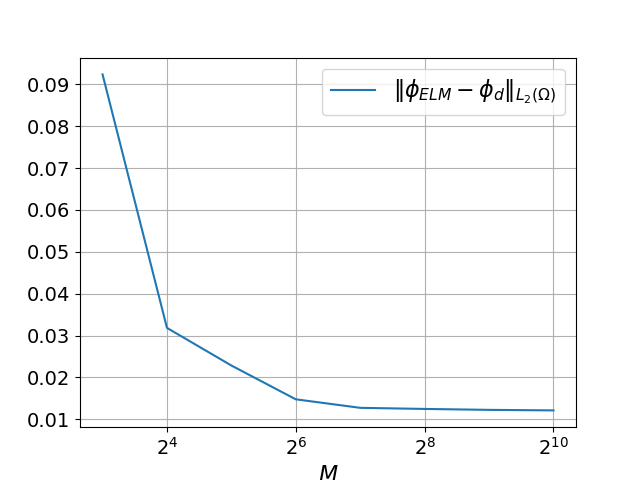

In [6]:
fig = plt.figure()
plt.plot([2 ** i for i in range(3,11)], errors_phi, label=r"$\|\phi_{ELM} - \phi_{d}\|_{L_2(\Omega)}$")
plt.xscale("log", base=2)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
plt.xlabel("$M$", fontsize=16)
plt.legend(fontsize=16)
fig.savefig("sphere_outward_mag_elm_error_phi.pdf")

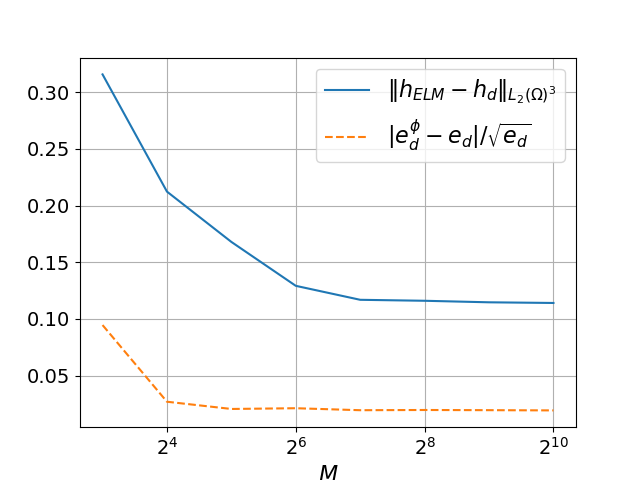

In [7]:
fig = plt.figure()
plt.plot([2 ** i for i in range(3,11)], errors_h, label=r"$\|h_{ELM} - h_{d}\|_{L_2(\Omega)^3}$")
plt.plot([2 ** i for i in range(3,11)], errors_energy, "--", label=r"$|e_{d}^{\phi} - e_d| / \sqrt{e_d}$")
plt.xscale("log", base=2)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
plt.xlabel("$M$", fontsize=16)
plt.legend(fontsize=16)
fig.savefig("sphere_outward_mag_elm_error_h.pdf")

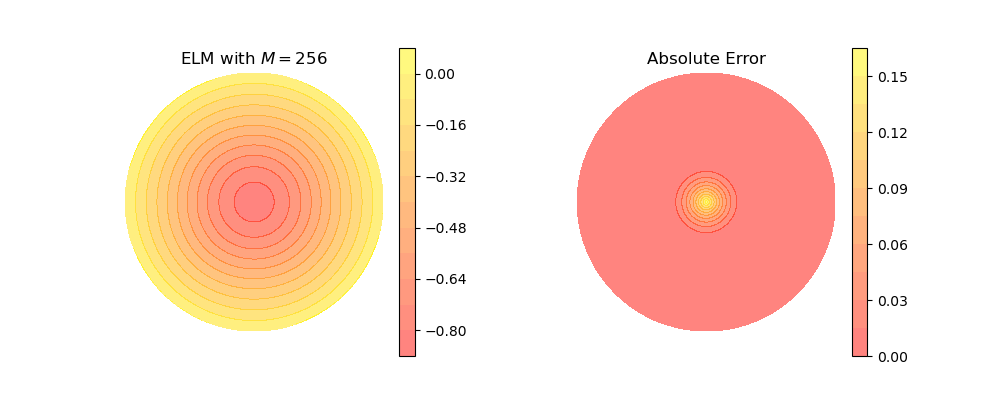

In [8]:
# compute the solution for 256 basis functions for plotting
_weights = array(Halton(4, seed=43).random(2 ** 8))
W_elm = (_weights[:, :3] * 2 - 1) * 2
b_elm = (_weights[:, 3] * 2 - 1) * 2
phi_pred = solve_stray_field(W_elm, b_elm) 

def plot_sol(sol, ax, log=False):
    plt.sca(ax)
    N = 1000
    x = np.linspace(-1, 1, N)
    z = np.linspace(-1, 1, N)
    X = np.array([_x for _x in itertools.product(x, z)])
    _X = jnp.asarray(X)
    _X = jnp.insert(_X, array([1]), zeros((N * N, 1)), 1)
    phi = np.array(lax.map(sol, _X))
    phi[np.linalg.norm(X, axis=-1) > 1.] = np.nan
    if log:
        p = ax.contourf(x, z, phi.reshape(N, N).T, 10, cmap=plt.get_cmap("autumn"), alpha=0.5, locator=ticker.LogLocator())
    else:
        p = ax.contourf(x, z, phi.reshape(N, N).T, 10, cmap=plt.get_cmap("autumn"), alpha=0.5)
    plt.colorbar(p)
    ax.set_axis_off()
    ax.set_aspect('equal')

fig = plt.figure(figsize=(10, 4))
ax1, ax2 = fig.subplots(1, 2)
plt.subplots_adjust(wspace=0.4)
ax1.set_title("ELM with $M=256$")
plot_sol(phi_pred, ax1)
ax2.set_title("Absolute Error")
plot_sol(jit(lambda x: abs(phi_pred(x) -  phi_true(x))), ax2, log=False)
fig.savefig("sphere_outward_mag_elm256.pdf")